# Week 7 Practical - Nearest Neighbours and Scaling Methods

Tools used:

- How to scale your data correctly (**StandardScaler** and **RobustScaler**)
- How scaling impacts **Nearest Neighbour methods** (classification and regression)


---

## 🟢 **1. Setup and Data Preparation**

**Step 1: Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.dummy
import sklearn.metrics
import sklearn.neighbors
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

---

## 🟢 **2. Load and Explore the Customer Churn Dataset**

We'll start with a dataset used for **classification** tasks (predicting "churn": whether customers leave or stay). There is a
file `WA_Fn-UseC_-Telco-Customer-Churn.csv` with some customer churn data for a telecommunications company. It is from https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Use `pd.read_csv` to load, then use some python commands look at the data (make additional cells if you need to). 

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\pc\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1


In [4]:
fname = glob(path + "/*.csv")[0]
df_churn = pd.read_csv(fname)
df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Quick check:**  
- Which columns can you see?
- Do they all look numeric?

Use `.value_counts()` to see how many different values there are in the `Churn` column.

In [5]:
df_churn.Churn.value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

---

## 🟢 **3. Selecting Numeric Features**

Nearest neighbours methods work well with numeric data. Let's pick three numeric columns:

- `tenure`: How long customers stay (months).
- `MonthlyCharges`: Monthly bill.
- `TotalCharges`: Total bill so far.

Create a dataframe called `df_churn` that has those features (plus "Churn") in it. Use the `.dropna()` method to drop any rows
that have nulls in them.

In [6]:
features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_churn = df_churn[features + ['Churn']].dropna()
df_churn.head()


,tenure,MonthlyCharges,TotalCharges,Churn
0,1,29.85,29.85,No
1,34,56.95,1889.5,No
2,2,53.85,108.15,Yes
3,45,42.30,1840.75,No
4,2,70.70,151.65,Yes


## 🟢 **4. Data cleanup**

We'll now do some slightly more complicated feature engineering. This is the probably first time you've seen something like this, so don't worry if it is a bit confusing at first. This kind of error correcting and data cleaning is often one of the largest tasks in a data science project.

Some of the "TotalCharges" have not been correctly recorded. Sometimes it comes up with ' ' instead. (Just a space character).

Let's just confirm that this really does happen: we'll look at the rows in the `df_churn` dataframe where that is the case.

In [16]:
df_churn[df_churn.TotalCharges == ' ']

,tenure,MonthlyCharges,TotalCharges,Churn
488,0,52.55,,No
753,0,20.25,,No
936,0,80.85,,No
1082,0,25.75,,No
1340,0,56.05,,No
3331,0,19.85,,No
3826,0,25.35,,No
4380,0,20.00,,No
5218,0,19.70,,No
6670,0,73.35,,No


Read that as "show me the df_churn rows at the locations where the df_churn.TotalCharges data series is equal to a space"

We can also turn that around, show me the rows where it isn't a space.

In [19]:
df_churn[df_churn.TotalCharges != ' ']

,tenure,MonthlyCharges,TotalCharges,Churn
0,1,29.85,29.85,No
1,34,56.95,1889.5,No
2,2,53.85,108.15,Yes
3,45,42.30,1840.75,No
4,2,70.70,151.65,Yes
...,...,...,...,...
7038,24,84.80,1990.5,No
7039,72,103.20,7362.9,No
7040,11,29.60,346.45,No
7041,4,74.40,306.6,Yes


And that's the dataframe we really want to have, so let's replace the `df_churn` dataframe with that dataframe that doesn't have any spaces in it.

In [20]:
df_churn = df_churn[df_churn.TotalCharges != ' ']

Unfortunately, it remembers that `df_churn` wasn't 100% numeric. It doesn't know that we've removed all the non-numeric data.

We can see this when we use the `.dtypes` attribute to show us the *types* of each column.

In [21]:
df_churn.dtypes

tenure              int64
MonthlyCharges    float64
TotalCharges       object
Churn              object
dtype: object

So we need to convert `TotalCharges` to being numeric. There is a pandas function called `to_numeric` that does this. It takes a Series as an argument, and returns a Series.

In [22]:
pd.to_numeric(df_churn.TotalCharges)

0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7032, dtype: float64

Let's set the `TotalCharges` column to being the numeric version of it.

In [23]:
df_churn.TotalCharges = pd.to_numeric(df_churn.TotalCharges)

## 🟢 **5. Split Data into Training and Test Sets**

We must always evaluate our model on data it hasn't "seen" yet. That's why we split our data.

Split the data into a training set, a validation set and a test set. Use `.shape` to confirm the sizes each of these.

In [24]:
train, temp = train_test_split(df_churn, test_size=0.4, random_state=42)
validation, test = train_test_split(temp, test_size=0.5, random_state=42)
train.shape, validation.shape, test.shape

((4219, 4), (1406, 4), (1407, 4))

What are the ranges of the features we are using for training? Dataframes have a `.describe()` method you can use.

In [25]:
train.tenure.describe()

count    4219.000000
mean       32.141266
std        24.596477
min         1.000000
25%         8.000000
50%        28.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

Let's visualise the histogram of these columns with `.plot.hist()`

<Axes: ylabel='Frequency'>

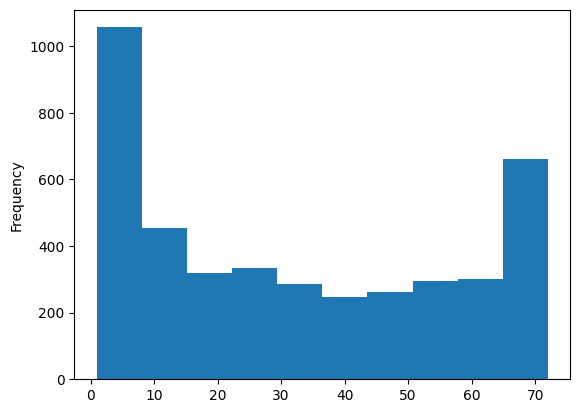

In [26]:
train.tenure.plot.hist()

<Axes: ylabel='Frequency'>

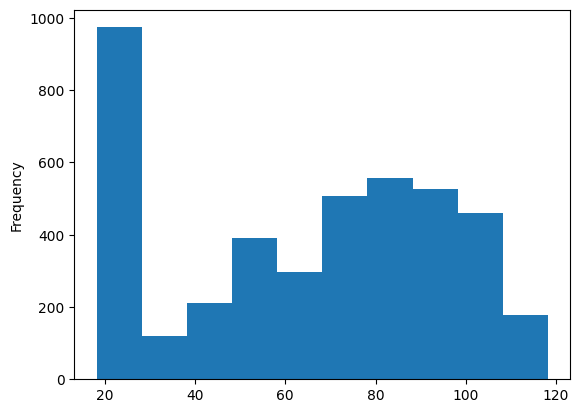

In [27]:
train.MonthlyCharges.plot.hist()

<Axes: ylabel='Frequency'>

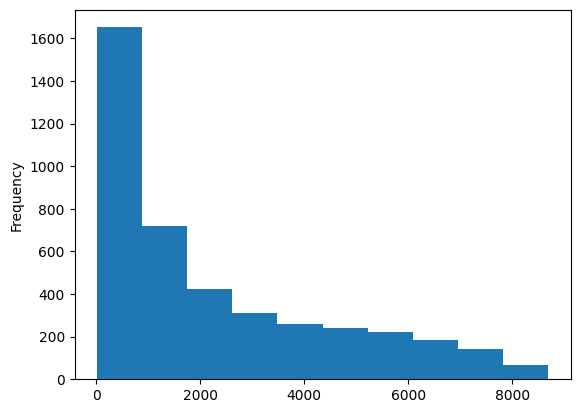

In [28]:
train.TotalCharges.plot.hist()

## 🟢 **6. Establish a baseline**

We often want to compare out results against a simple baseline -- if we assume everyone is not going to churn (which is the most
common case). Create a `DummyClassifier` using the "most_frequent" strategy), and run inference on the validation data ("run inference" means "make predictions").

It really doesn't matter all that much whether you use the validation or test data to evaluate it since it doesn't pay any 
attention to the data it is given, as you will see if you look at the predictions.

In [29]:
dummy = sklearn.dummy.DummyClassifier(strategy='most_frequent')
dummy.fit(train[['tenure', 'MonthlyCharges', 'TotalCharges']], train.Churn)
dummy_validation_pred = dummy.predict(validation[['tenure', 'MonthlyCharges', 'TotalCharges']])
dummy_validation_pred

array(['No', 'No', 'No', ..., 'No', 'No', 'No'],
      shape=(1406,), dtype='<U2')

Measure how well it works: give an accuracy score, a confusion matrix and a classification report.

In [30]:
sklearn.metrics.accuracy_score(validation.Churn, dummy_validation_pred)

0.7354196301564723

In [31]:
sklearn.metrics.confusion_matrix(validation.Churn, dummy_validation_pred)

array([[1034,    0],
       [ 372,    0]])

In [32]:
print(sklearn.metrics.classification_report(validation.Churn, dummy_validation_pred))

              precision    recall  f1-score   support

          No       0.74      1.00      0.85      1034
         Yes       0.00      0.00      0.00       372

    accuracy                           0.74      1406
   macro avg       0.37      0.50      0.42      1406
weighted avg       0.54      0.74      0.62      1406



P:\OneDrive - Macquarie University\Master's Program\Master UNit guide\COMP6200 - Data Science\WorkShop\data-science-backup\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
P:\OneDrive - Macquarie University\Master's Program\Master UNit guide\COMP6200 - Data Science\WorkShop\data-science-backup\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
P:\OneDrive - Macquarie University\Master's Program\Master UNit guide\COMP6200 - Data Science\WorkShop\data-science-backup\.venv\Lib\site-packages\sklea

## 🟢 **7. What happens if we don't scale the data?**

Each feature has quite a different scale, so whichever feature is the smallest is the one that will have the most impact on the result.

Let's look at that. Let’s classify customer churn using **KNearestNeighborsClassifier**. Try with `n_neighbors=1`

In [33]:

knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
knn.fit(train[['tenure', 'MonthlyCharges', 'TotalCharges']], train.Churn)

KNeighborsClassifier()

Predict the data in the validation set

In [34]:
y_pred = knn.predict(validation[['tenure', 'MonthlyCharges', 'TotalCharges']])
print("First 10 predictions:", y_pred[:10], "\n")

First 10 predictions: ['No' 'No' 'Yes' 'No' 'No' 'No' 'Yes' 'Yes' 'No' 'No'] 



Evaluate the accuracy on the validation set, and print out a classification report.

In [35]:
sklearn.metrics.accuracy_score(validation.Churn, y_pred)

0.7695590327169275

In [36]:
sklearn.metrics.confusion_matrix(validation.Churn, y_pred)



array([[923, 111],
       [213, 159]])

In [38]:
# print out classification data
# Print value counts for the target column 'Churn'
class_counts = df_churn['Churn'].value_counts()
print("Class Distribution:")
print(class_counts)


Class Distribution:
Churn
No     5163
Yes    1869
Name: count, dtype: int64


**Discussion point:**  
- Is the accuracy of this model better or worse than the dummy model?
- Try changing the number of neighbours (`n_neighbors`). Does accuracy improve?

---

## 🟢 **8. Scaling your Data (StandardScaler)**

Scaling is important because nearest neighbours rely on distances between points. Different scales can bias distances.

**Step 8.1: Scaling the training data**

Create an `sklearn.preprocessing.StandardScaler` object. Use its `.fit_transform()` method to create an array of scaled data from the training
data. Note that you should only try to scale the numeric columns. Save it in a variable called `X_train_scaled` so that the following cell
works correctly.

In [39]:
scaler_std = sklearn.preprocessing.StandardScaler()
X_train_scaled = scaler_std.fit_transform(train[['tenure', 'MonthlyCharges', 'TotalCharges']])

**Explanation:**  
- **`fit_transform`** calculates the mean and standard deviation from the **training data only**, then scales it.

**Quick Check:**  
- How has the data changed? Let's see visually!

Enter this new cell:

C:\Users\pc\AppData\Local\Temp\ipykernel_24316\243638215.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(X_train_scaled, labels=features, vert=False)


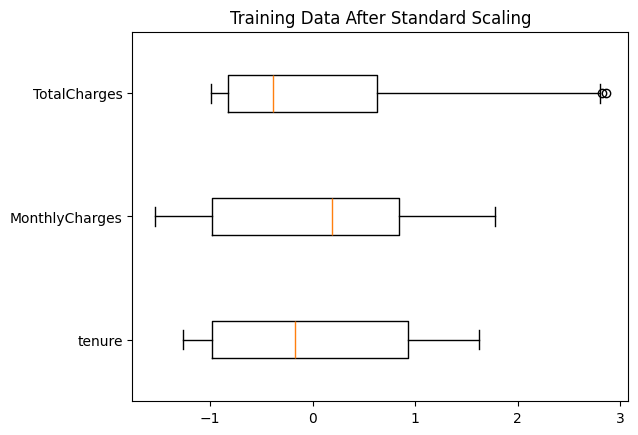

In [40]:
plt.boxplot(X_train_scaled, labels=features, vert=False)
plt.title("Training Data After Standard Scaling")
plt.show()

## 🟢 **9. Scaling the Test Data Correctly**

We must apply the **same scaler** (trained on our training set) to the test data. But we don't want to retrain the scaler -- it should use the same numbers for adjusting the mean and the stddev as was applied to the training set.


```python

In [41]:
X_validation_scaled = scaler_std.transform(validation[['tenure', 'MonthlyCharges', 'TotalCharges']])

**Explanation:**  
- We used `transform` (**not fit_transform**!) because we shouldn't learn scaling parameters from the test set.

---

## 🟢 **10. Does the scaled data give better results?**

Repeat the same code from section 7, but use the scaled data.

In [42]:
knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, train.Churn)
y_pred = knn.predict(X_validation_scaled)
sklearn.metrics.accuracy_score(validation.Churn, y_pred)

0.7162162162162162

In [43]:
sklearn.metrics.confusion_matrix(validation.Churn, y_pred)

array([[844, 190],
       [209, 163]])

## 🔵 **11. Using RadiusNeighboursClassifier (Customer Churn)**

RadiusNeighboursClassifier finds all neighbours within a given radius rather than a fixed number of neighbours.

In [44]:
# Create classifier with a chosen radius
radius_clf = sklearn.neighbors.RadiusNeighborsClassifier(radius=1.5)

# Train the classifier
radius_clf.fit(X_train_scaled, train.Churn)

RadiusNeighborsClassifier(radius=1.5)

```

**Explanation:**  
- Radius = 1.5 means all points within a "distance" of 1.5 from a new point will vote on its classification.
- If no points fall within the radius, it won't classify (special cases occur).

---

Predict and evaluate as you've done for all the other classifiers:

In [45]:
y_radius_pred = radius_clf.predict(X_validation_scaled)
sklearn.metrics.accuracy_score(validation.Churn, y_radius_pred)

0.7460881934566145

In [46]:
sklearn.metrics.confusion_matrix(validation.Churn, y_radius_pred)

array([[1023,   11],
       [ 346,   26]])

In [47]:
print(sklearn.metrics.classification_report(validation.Churn, y_radius_pred))

              precision    recall  f1-score   support

          No       0.75      0.99      0.85      1034
         Yes       0.70      0.07      0.13       372

    accuracy                           0.75      1406
   macro avg       0.72      0.53      0.49      1406
weighted avg       0.74      0.75      0.66      1406



**Discussion point:**  
- What happens if the radius is too small or too large?
- When might radius-based neighbours be more appropriate?

---

We would normally now decide which classifier was the best (and which `n_neighbors` was the best) and then evaluate that on the test dataset.

Just to save some time in the prac we have removed that.

## 🟢 **12. RobustScaler Example (Diabetes Regression)**

Now let's repeat the same clearly explained steps for a **regression** problem, using the diabetes dataset.
 
There is a library on diabetes progression built in to scikit learn. Since we aren't going to compare any models,
we can do without the validation dataset.

In [48]:
import sklearn.datasets

diabetes = sklearn.datasets.load_diabetes(as_frame=True)
X_dia = diabetes.data
y_dia = diabetes.target

X_dia_train, X_dia_test, y_dia_train, y_dia_test = sklearn.model_selection.train_test_split(
    X_dia, y_dia, test_size=0.3, random_state=42)

print("Diabetes Training set:", X_dia_train.shape)
print("Diabetes Test set:", X_dia_test.shape)

Diabetes Training set: (309, 10)
Diabetes Test set: (133, 10)


## 🟢 **13. Scaling Diabetes Data (RobustScaler)**

This dataset may have outliers. We'll use **RobustScaler**.

In [49]:
scaler_robust = sklearn.preprocessing.RobustScaler()
X_dia_train_scaled = scaler_robust.fit_transform(X_dia_train)

**Explanation:**

The **RobustScaler** scales data according to:

$ X_{\text{scaled}} = \frac{X - \text{median}(X)}{\text{IQR}(X)} $

where the interquartile range (IQR) is defined as:

$ \text{IQR}(X) = Q_{3}(X) - Q_{1}(X) $

- $Q_{1}(X)$: 25th percentile (first quartile)
- $Q_{3}(X)$: 75th percentile (third quartile)


## 🔵 **14. KNeighboursRegressor (Diabetes regression)**

Now let's use k-nearest neighbours for *regression*. Make a regressor with `n_neighbors=5`. Fit on the training data 
and predict the test data.

In [50]:
knn_reg = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_dia_train_scaled, y_dia_train)

X_dia_test_scaled = scaler_robust.transform(X_dia_test)
y_dia_pred = knn_reg.predict(X_dia_test_scaled)

We are evaluating a regressor, so we'll need to use a metric that is appropriate for evaluating regressors, like r^2 score or mean
square error.

In [51]:
sklearn.metrics.mean_squared_error(y_dia_test, y_dia_pred)

3220.2604511278196

In [52]:
sklearn.metrics.r2_score(y_dia_test, y_dia_pred)

0.4034685325160472

It is often helpful to visualise the test predictions to understand how the regressor worked.

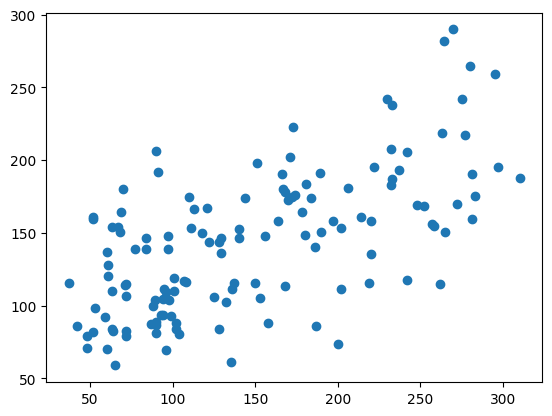

In [53]:
plt.scatter(x=y_dia_test, y=y_dia_pred)

**Discussion point:**  
- Does changing the number of neighbours affect MSE?
- What would be a good way to choose the best number of neighbours?

---

## ✅ **Recap:**

You’ve now explicitly:

- Used **KNeighboursClassifier** for churn prediction.
- Tried **RadiusNeighboursClassifier** to explore radius-based neighbours.
- Applied **KNeighboursRegressor** for diabetes progression prediction.